# I. Upload File, Install Modules, Import Libraries

In [32]:
from google.colab import files
files.upload()

Saving metal_music_data.csv to metal_music_data (1).csv


{'metal_music_data.csv': b'Artist Name,Track Name,Popularity,Genres,Playlist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,uri,track_href,analysis_url,duration_ms,time_signature\r\nMyrkur,Ella,42,"[\'autonomous black metal\', \'avant-garde metal\', \'danish black metal\', \'danish metal\', \'gaian doom\', \'medieval folk\', \'post-black metal\', \'rune folk\']",Northern Spirits,0.24,0.313,5,-11.476,1,0.033,0.791,0.000156,0.176,0.131,101.673,6QXieDRlH4Ofjg864USffV,spotify:track:6QXieDRlH4Ofjg864USffV,https://api.spotify.com/v1/tracks/6QXieDRlH4Ofjg864USffV,https://api.spotify.com/v1/audio-analysis/6QXieDRlH4Ofjg864USffV,234923,3\r\nMonuments,Deadnest,51,[\'djent\'],Kickass Metal,0.445,0.968,6,-2.563,1,0.207,1.29E-05,9.99E-06,0.338,0.326,114.92,3IC74qNKqXdeydqyS1J5z5,spotify:track:3IC74qNKqXdeydqyS1J5z5,https://api.spotify.com/v1/tracks/3IC74qNKqXdeydqyS1J5z5,https://api.spotify.com/v1/audio-analysis/3IC74qNKqXdeydqyS1J5z5,20739

In [2]:
%%capture 
!pip install category_encoders==2.*
!pip install pandas_profiling==2.*
!pip install pdpbox
!pip install shap
!pip install imbalanced-learn

In [3]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.inspection import permutation_importance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from pandas_profiling import ProfileReport
from scipy.stats import loguniform
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
import shap
import sys

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
filepath = 'metal_music_data.csv'

# II. Preliminary Data Exploration

In [5]:
df1 = pd.read_csv(filepath)
df1 = df1.drop_duplicates(subset=['id'])

In [6]:
df1.shape

(2613, 22)

In [7]:
df1.head()

,Artist Name,Track Name,Popularity,Genres,Playlist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Myrkur,Ella,42,"['autonomous black metal', 'avant-garde metal'...",Northern Spirits,0.240,0.313,5,-11.476,1,0.0330,0.791000,0.000156,0.176,0.1310,101.673,6QXieDRlH4Ofjg864USffV,spotify:track:6QXieDRlH4Ofjg864USffV,https://api.spotify.com/v1/tracks/6QXieDRlH4Of...,https://api.spotify.com/v1/audio-analysis/6QXi...,234923,3
1,Monuments,Deadnest,51,['djent'],Kickass Metal,0.445,0.968,6,-2.563,1,0.2070,0.000013,0.000010,0.338,0.3260,114.920,3IC74qNKqXdeydqyS1J5z5,spotify:track:3IC74qNKqXdeydqyS1J5z5,https://api.spotify.com/v1/tracks/3IC74qNKqXde...,https://api.spotify.com/v1/audio-analysis/3IC7...,207391,4
2,The Southern Oracle,Prisoner,20,"['hungarian metal', 'magyar alternative']",Thrashers,0.510,0.989,1,-3.660,0,0.3760,0.000124,0.000062,0.410,0.3710,99.889,4ykGftnKT3rol4IfnE1pHw,spotify:track:4ykGftnKT3rol4IfnE1pHw,https://api.spotify.com/v1/tracks/4ykGftnKT3ro...,https://api.spotify.com/v1/audio-analysis/4ykG...,141400,4
3,Insomnium,The Reticent,0,"['finnish death metal', 'finnish melodeath', '...",New Metal Tracks,0.498,0.833,7,-8.872,0,0.0405,0.000165,0.049700,0.123,0.1210,117.962,07PFzxEUNcMIwghKcrFGgF,spotify:track:07PFzxEUNcMIwghKcrFGgF,https://api.spotify.com/v1/tracks/07PFzxEUNcMI...,https://api.spotify.com/v1/audio-analysis/07PF...,272616,4
4,Galleons,Playing With Fire is Such a Cliché,42,"['progressive post-hardcore', 'swancore']",New Metal Tracks,0.471,0.925,7,-4.633,1,0.0598,0.000254,0.000027,0.356,0.0768,100.012,4c1iQXXJundtYEWroDRku7,spotify:track:4c1iQXXJundtYEWroDRku7,https://api.spotify.com/v1/tracks/4c1iQXXJundt...,https://api.spotify.com/v1/audio-analysis/4c1i...,303000,4


In [8]:
report = ProfileReport(df1, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/31 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
df1.Popularity.describe()

count    2613.000000
mean       41.613088
std        14.445571
min         0.000000
25%        33.000000
50%        41.000000
75%        50.000000
max        84.000000
Name: Popularity, dtype: float64

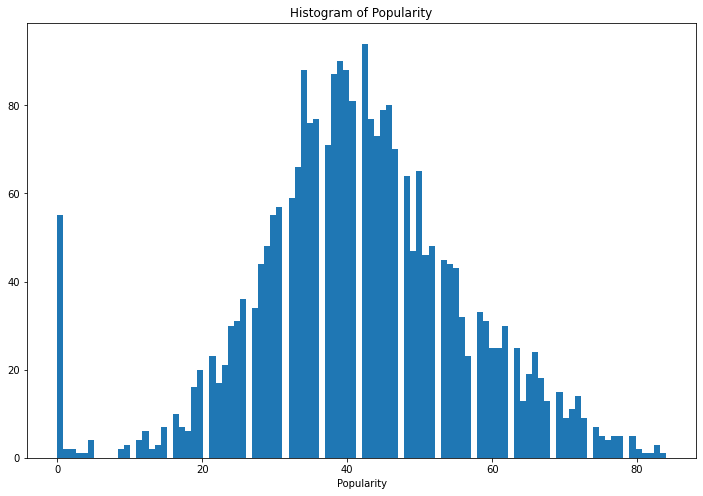

In [10]:
plt.figure(figsize=(12,8))
plt.hist(df1.Popularity, bins=100)
plt.xlabel('Popularity')
plt.title('Histogram of Popularity')
plt.show()

# III. Regression
Predicting the Popularity Score

In [11]:
# wrangle

def wrangle(filepath):
  dfreg = pd.read_csv(filepath)

  #eliminate duplicate rows

  dfreg = dfreg.drop_duplicates(subset=['id'])

  # set 'id' as index

  dfreg.set_index('id', inplace=True)

  # eliminate high-cardinality columns
  
  categorical_columns = dfreg.select_dtypes('object').columns

  high_card_cols =  [col for col in categorical_columns
                     if dfreg[col].nunique() > 20]
  dfreg.drop(high_card_cols, axis=1, inplace=True)

  # encode key, mode, and time_signature columns
  
  dfreg = pd.get_dummies(dfreg, columns=['key', 'mode', 'time_signature'], prefix=['key', 'mode', 'time'])

  return dfreg

In [12]:
dfreg = wrangle(filepath)

In [13]:
dfreg.head()

,Popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1,time_1,time_3,time_4,time_5
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6QXieDRlH4Ofjg864USffV,42,0.240,0.313,-11.476,0.0330,0.791000,0.000156,0.176,0.1310,101.673,234923,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
3IC74qNKqXdeydqyS1J5z5,51,0.445,0.968,-2.563,0.2070,0.000013,0.000010,0.338,0.3260,114.920,207391,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
4ykGftnKT3rol4IfnE1pHw,20,0.510,0.989,-3.660,0.3760,0.000124,0.000062,0.410,0.3710,99.889,141400,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
07PFzxEUNcMIwghKcrFGgF,0,0.498,0.833,-8.872,0.0405,0.000165,0.049700,0.123,0.1210,117.962,272616,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
4c1iQXXJundtYEWroDRku7,42,0.471,0.925,-4.633,0.0598,0.000254,0.000027,0.356,0.0768,100.012,303000,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0


In [14]:
dfreg.shape

(2613, 29)

# IIIa. Split Data for Regression

In [15]:
# Split data into target vector and feature matrix 

targetreg = 'Popularity'
y_reg = dfreg[targetreg]
X_reg = dfreg.drop(columns=targetreg)

In [16]:
# Train-validation split

X_reg_train, X_reg_val, y_reg_train, y_reg_val = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train-test split

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg_train, y_reg_train, test_size=0.2, random_state=42)

In [17]:
print(X_reg_train.shape)
print(y_reg_train.shape)
print(X_reg_val.shape)
print(y_reg_val.shape)
print(X_reg_test.shape)
print(y_reg_test.shape)

(1672, 28)
(1672,)
(523, 28)
(523,)
(418, 28)
(418,)


# IIIb. Establish Baseline Accuracy for Regression Models

In [18]:
print('Mean Popularity:', y_reg_train.mean())

y_reg_pred = [y_reg_train.mean()] * len(y_reg_train)
print('Baseline MAE', mean_absolute_error(y_reg_train, y_reg_pred))

Mean Popularity: 41.520933014354064
Baseline MAE 11.174221200293035


# IIIc. Build Regression Models

In [19]:
model_lr = LinearRegression()
model_r = Ridge()
model_rfr = RandomForestRegressor(n_jobs=-1, random_state=42)
model_xgbr = XGBRegressor(n_jobs=-1, random_state=42)

In [20]:
model_lr.fit(X_reg_train, y_reg_train)
model_r.fit(X_reg_train, y_reg_train)
model_rfr.fit(X_reg_train, y_reg_train)
model_xgbr.fit(X_reg_train, y_reg_train)

[14:06:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_jobs=-1, random_state=42)

# IIId. Check Metrics

In [21]:
def check_metrics(model):
  # print(model)
  print('Training MAE:', mean_absolute_error(y_reg_train, model.predict(X_reg_train)))
  print('Validation MAE:', mean_absolute_error(y_reg_val, model.predict(X_reg_val)))
  print('Validation R^2:', model.score(X_reg_val, y_reg_val))
  print()
  print()

models = [model_lr, model_r, model_rfr, model_xgbr]

for m in models:
  check_metrics(m)

Training MAE: 10.46550889764746
Validation MAE: 10.535014039046429
Validation R^2: 0.11358406454152548


Training MAE: 10.461785563999124
Validation MAE: 10.525595410116587
Validation R^2: 0.11345846635917489


Training MAE: 3.9332177033492823
Validation MAE: 10.57942638623327
Validation R^2: 0.09402856889519884


Training MAE: 8.642648772189492
Validation MAE: 10.734736076048637
Validation R^2: 0.07685842702910994




# IIIe. Tune Ridge Model

In [22]:
params = {'alpha': (np.logspace(-8, 8, 100))} 
ridge = Ridge(normalize=True)
tuned_ridge = GridSearchCV(
    ridge, 
    params, 
    cv = 10
    )

tuned_ridge.fit(X_reg, y_reg)

print('Best Parameters for Ridge Regression: ', tuned_ridge.best_params_)
print('Best Score for Ridge Regression: ', tuned_ridge.best_score_)

Best Parameters for Ridge Regression:  {'alpha': 0.04229242874389508}
Best Score for Ridge Regression:  0.09545750372021782


# IIIf. Test Results of Tuned Ridge Model

In [23]:
print('Testing MAE: ', mean_absolute_error(y_reg_test, tuned_ridge.predict(X_reg_test)))
print('Testing R^2: ', tuned_ridge.score(X_reg_test, y_reg_test))

Testing MAE:  9.586970562497392
Testing R^2:  0.09561447131276457


# IV. Convert to Classification Problem
Rather than predict an exact score, will try to predict if a song is popular or not (Popularity score >= 50; 75th percentile of the dataset)

In [24]:
# wrangle

def wrangle2(filepath):
  dftree = pd.read_csv(filepath)

  #eliminate duplicate rows

  dftree = dftree.drop_duplicates(subset=['id'])

  # set 'id' as index

  dftree.set_index('id', inplace=True)

  
  # eliminate high-cardinality columns
  
  categorical_columns = dftree.select_dtypes('object').columns

  high_card_cols =  [col for col in categorical_columns
                     if dftree[col].nunique() > 20]
  dftree.drop(high_card_cols, axis=1, inplace=True)

  # encode key, mode, and time_signature columns
  
  dftree = pd.get_dummies(dftree, columns=['key', 'mode', 'time_signature'], prefix=['key', 'mode', 'time'])

  # add is_popular column to make it a binary classification problem, selecting for the top quartile

  dftree['is_popular'] = dftree.Popularity.apply(lambda value: 1 if value >= 50 else 0)
  dftree.drop(columns='Popularity', inplace=True)

  return dftree

In [25]:
dftree = wrangle2(filepath)

In [26]:
dftree.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1,time_1,time_3,time_4,time_5,is_popular
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6QXieDRlH4Ofjg864USffV,0.240,0.313,-11.476,0.0330,0.791000,0.000156,0.176,0.1310,101.673,234923,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
3IC74qNKqXdeydqyS1J5z5,0.445,0.968,-2.563,0.2070,0.000013,0.000010,0.338,0.3260,114.920,207391,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1
4ykGftnKT3rol4IfnE1pHw,0.510,0.989,-3.660,0.3760,0.000124,0.000062,0.410,0.3710,99.889,141400,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
07PFzxEUNcMIwghKcrFGgF,0.498,0.833,-8.872,0.0405,0.000165,0.049700,0.123,0.1210,117.962,272616,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
4c1iQXXJundtYEWroDRku7,0.471,0.925,-4.633,0.0598,0.000254,0.000027,0.356,0.0768,100.012,303000,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0


In [27]:
dftree.shape

(2613, 29)

In [28]:
dftree.is_popular.value_counts(normalize=True)

0    0.732491
1    0.267509
Name: is_popular, dtype: float64

# IV. Split Data for Classification

In [29]:
# Split data into target vector and feature matrix

targettree = 'is_popular'
y_tree = dftree[targettree]
X_tree = dftree.drop(columns=targettree)

In [30]:
# SMOTE to balance the data

smote = SMOTE(sampling_strategy='minority')
X_smote, y_smote = smote.fit_resample(X_tree, y_tree)

In [31]:
y_smote.value_counts(normalize=True)

1    0.5
0    0.5
Name: is_popular, dtype: float64

In [ ]:
# Train-validation split

X_tree_train, X_tree_val, y_tree_train, y_tree_val = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# Train-test split

X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_tree_train, y_tree_train, test_size=0.2, random_state=42)

In [ ]:
print(X_tree_train.shape)
print(y_tree_train.shape)
print(X_tree_val.shape)
print(y_tree_val.shape)
print(X_tree_test.shape)
print(y_tree_test.shape)

(2449, 28)
(2449,)
(766, 28)
(766,)
(613, 28)
(613,)


# IVb. Establish Baseline Accuracy

In [ ]:
y_tree_train.value_counts(normalize=True)

1    0.507146
0    0.492854
Name: is_popular, dtype: float64

In [ ]:
# Establish Baseline Accuracy

print('Baseline Accuracy:', y_tree_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5071457737852184


# IVc. Build Classification Models

In [ ]:
# Logistic Regression

model_logr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(random_state=42, n_jobs=-1)
)

model_logr.fit(X_tree_train, y_tree_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(n_jobs=-1, random_state=42))])

In [ ]:
# Random Forest Classifier

model_rfc = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

model_rfc.fit(X_tree_train, y_tree_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

In [ ]:
# Gradient Boosting Classifier

model_gbc = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    GradientBoostingClassifier(random_state=42, n_estimators=75) 
)

model_gbc.fit(X_tree_train, y_tree_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(n_estimators=75, random_state=42))])

In [ ]:
# XGBoost

model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=42, n_estimators=75, n_jobs=-1) 
)

model_xgb.fit(X_tree_train, y_tree_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('xgbclassifier',
                 XGBClassifier(n_estimators=75, n_jobs=-1, random_state=42))])

# IVd. Check Classification Metrics

In [ ]:
# Training and Validation Accuracy

print('Logistic Regression')
print('Training Accuracy Score:', model_logr.score(X_tree_train, y_tree_train))
print('Validation Accuracy Score', model_logr.score(X_tree_val, y_tree_val))
print()
print()
print('Random Forest Classifier')
print('Training Accuracy Score:', model_rfc.score(X_tree_train, y_tree_train))
print('Validation Accuracy Score', model_rfc.score(X_tree_val, y_tree_val))
print()
print()
print('Gradient Boosting Classifier')
print('Training Accuracy Score:', model_gbc.score(X_tree_train, y_tree_train))
print('Validation Accuracy Score:', model_gbc.score(X_tree_val, y_tree_val))
print()
print()
print('XGBoost')
print('Training Accuracy Score:', model_xgb.score(X_tree_train, y_tree_train))
print('Validation Accuracy Score:', model_xgb.score(X_tree_val, y_tree_val))

Logistic Regression
Training Accuracy Score: 0.8080849326255615
Validation Accuracy Score 0.7989556135770235


Random Forest Classifier
Training Accuracy Score: 1.0
Validation Accuracy Score 0.7963446475195822


Gradient Boosting Classifier
Training Accuracy Score: 0.8579011841567987
Validation Accuracy Score: 0.7754569190600522


XGBoost
Training Accuracy Score: 0.84238464679461
Validation Accuracy Score: 0.7780678851174935


# IVe. Tune Models

In [ ]:
# Logistic Regression

clog = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(random_state=42, n_jobs=-1)
)

Lparam_grid = {
    'simpleimputer__strategy': ['mean', 'median'],
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

tuned_log = RandomizedSearchCV(
    clog,
    param_distributions=Lparam_grid,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = -1,
    verbose = 1,
    n_iter = 25
)

tuned_log.fit(X_smote, y_smote)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('onehotencoder',
                                              OneHotEncoder(use_cat_names=True)),
                                             ('simpleimputer', SimpleImputer()),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('logisticregression',
                                              LogisticRegression(n_jobs=-1,
                                                                 random_state=42))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'logisticregression__C': [0.001, 0.01,
                                                                  0.1, 1, 10,
                                                                  100, 1000],
                                        'logisticregression__penalty': ['l1',
                                   

In [ ]:
print('Best score for Tuned Logistic Regression:', tuned_log.best_score_)
print('Best parameters for Tuned Logistic Regression:', tuned_log.best_params_)

Best score for Tuned Logistic Regression: 0.7968442852651293
Best parameters for Tuned Logistic Regression: {'simpleimputer__strategy': 'mean', 'logisticregression__solver': 'liblinear', 'logisticregression__penalty': 'l1', 'logisticregression__C': 1000}


In [ ]:
# Random Forest Classifier

crf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1))

param_grid = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__max_depth': range(5, 40, 5),
    'randomforestclassifier__n_estimators': range(25, 125, 25),
    'randomforestclassifier__max_samples': np.arange(0.1, 1.1, 0.1),
    'randomforestclassifier__max_features': range(1, 31, 2)
}

tuned_rfc = RandomizedSearchCV(
    crf,
    param_distributions = param_grid,
    cv = 10,
    n_jobs = -1,
    verbose = 1,
    n_iter = 25
)

tuned_rfc.fit(X_smote, y_smote)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(5, 40, 5),
                                        'randomforestclassifier__max_features': range(1, 31, 2),
                                        'randomforestclassifier__max_samples': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'randomforestclassifier__n_estimators': range(25, 125, 25),
                                        'simpleimput

In [ ]:
print('Best score for Tuned Random Forest Classifier:', tuned_rfc.best_score_)
print('Best parameters for Tuned Random Forest Classifier:', tuned_rfc.best_params_)

Best score for Tuned Random Forest Classifier: 0.8017729963227754
Best parameters for Tuned Random Forest Classifier: {'simpleimputer__strategy': 'mean', 'randomforestclassifier__n_estimators': 75, 'randomforestclassifier__max_samples': 0.7000000000000001, 'randomforestclassifier__max_features': 3, 'randomforestclassifier__max_depth': 35}


# IVf. Test Results of Tuned Models

In [ ]:
print('Tuned Logistic Regression Testing Score: ', tuned_log.score(X_tree_test, y_tree_test))
print('Tuned Random Forest Classifier Testing Score:', tuned_rfc.score(X_tree_test, y_tree_test))

Tuned Logistic Regression Testing Score:  0.8368678629690048
Tuned Random Forest Classifier Testing Score: 0.99836867862969


# V. Analysis

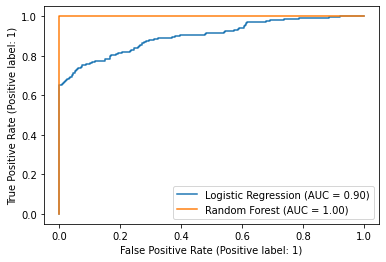

In [ ]:
# ROC curve

lr = plot_roc_curve(tuned_log,
               X_tree_test,
               y_tree_test,
               name="Logistic Regression");
rf = plot_roc_curve(tuned_rfc,
               X_tree_test,
               y_tree_test,
               ax=lr.ax_,
               name="Random Forest");

In [ ]:
# ROC-AUC scores

print('Logistic Regression ROC-AUC Score: ', roc_auc_score(y_tree_test, tuned_log.predict_proba(X_tree_test)[:,-1]))
print('Random Forest Classifier ROC-AUC Score: ', roc_auc_score(y_tree_test, tuned_rfc.predict_proba(X_tree_test)[:,-1]))

Logistic Regression ROC-AUC Score:  0.9008309364014062
Random Forest Classifier ROC-AUC Score:  1.0


Text(0, 0.5, 'Feature')

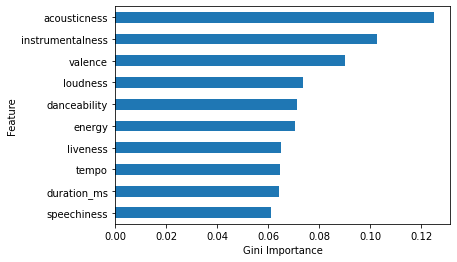

In [ ]:
# Feature Importances

importances = model_rfc.named_steps['randomforestclassifier'].feature_importances_
feature_names = X_tree_train.columns
feat_imp = pd.Series(data=importances, index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')